<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/rnn_scaled_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predviđanje vrednosti bitkoina korišćenjem RNN**

**Korišćeni atributi:** Open, High, Low, Close

**Filtrirani podaci:** od 28.03.2021.

Ova sveska je slična prethodnoj (svesci "rnn_scaled_dataset.ipynb"), sa razlikom što je ovde pokušano skaliranje trening, validacionog i test skupa pre određivanja ciljne promenljive. Posledica ovog postupka je to da predviđene vrednosti nisu izražene na istoj skali kao date vrednosti podataka.

## **Učitavanje biblioteka**

In [10]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from keras.layers import Dropout
#from keras import callbacks
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

%run 02_Preprocessing_and_data_analysis.ipynb
%run 03_Utility_functions.ipynb

## **Učitavanje skupa podataka i pretprocesiranje**

In [11]:
data = preprocess_data(file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [14]:
# Filtriranje podataka

data = filter_data(data, date_str = '2021-03-28')

In [13]:
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
4854496,1616976000,55790.28,55822.98,55777.98,55804.36,1.731449,96636.546983,55812.518695,2021-03-29
4854497,1616976060,55822.98,55857.28,55822.98,55857.28,0.589603,32931.781301,55854.182542,2021-03-29
4854498,1616976120,55822.98,55829.04,55766.15,55779.04,2.729659,152263.034630,55780.964698,2021-03-29
4854500,1616976240,55766.15,55768.63,55766.15,55768.63,0.023738,1323.776861,55766.455065,2021-03-29
4854501,1616976300,55770.46,55778.48,55736.83,55742.20,0.389067,21692.454676,55755.006032,2021-03-29
...,...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021-03-30


### **Podela skupa podataka**

In [ ]:
# Podela inicijalnog skupa podataka na train i test skup

train, test = data_split(data, test_size = 0.2)


# Podela train skupa podataka na train i validacioni skup

train, validation = data_split(train, test_size = 0.2)

In [ ]:
# Dimenzije train, validation i test skupa

train.shape, validation.shape, test.shape

((1839, 9), (459, 9), (574, 9))

### **Vizualizacija validacionog skupa i trening skupa**

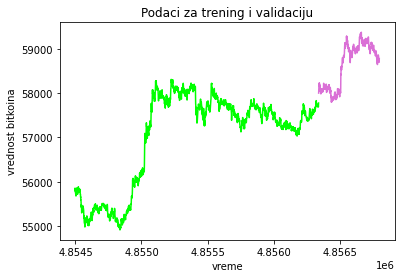

In [ ]:
plot_train_and_validation_data(train = train['Close'], validation = validation['Close'])

### **Filtriranje trening, validacionog i test skupa**

In [ ]:
# Izbacivanje nepotrebnih kolona (atributa) iz trening skupa

train_ = train.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
# train_.head(), train_.shape

In [ ]:
# Izbacivanje nepotrebnih kolona (atributa) iz validacionog skupa

validation_ = validation.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
# validation_.head(), validation_.shape

In [ ]:
# Izbacivanje nepotrebnih kolona (atributa) iz test skupa

test_ = test.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
# test_.head(), test_.shape

In [ ]:
# Dimenzije train skupa - pre i nakon izbacivanja atributa

# train.shape, train_.shape

### **Skaliranje**

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_ = scaler.fit_transform(train_)
validation_ = scaler.transform(validation_)
test_ = scaler.transform(test_)

### **Odredjivanje ciljne promenljive**

In [ ]:
# Odredjivanje ciljne promenljive na train skupu

X_train, y_train = determine_x_and_y(dataset = train_)


# Odredjivanje ciljne promenljive na validacionom skupu

X_validation, y_validation = determine_x_and_y(dataset = validation_)


# Odredjivanje ciljne promenljive na test skupu

X_test, y_test = determine_x_and_y(dataset = test_)

In [ ]:
# type(X_train), type(y_train)

In [ ]:
# Konverzija u np.array

X_train, y_train = np.array(X_train), np.array(y_train)
X_validation, y_validation = np.array(X_validation), np.array(y_validation)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
# Dimenzije X_train

# X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

### **Kreiranje, kompilacija i treniranje mreže**

**Kreiranje mreže**

In [ ]:
# Definicija funkcije koja kreira i vraca model mreze

def build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2]):

  net = Sequential()
  net.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (input_1, input_2)))
  net.add(Dropout(0.2))
  net.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.3))

  net.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.4))

  net.add(LSTM(units = 120, activation = 'relu'))
  net.add(Dropout(0.5))

  net.add(Dense(units =1))
  print(net.summary())

  return net


In [ ]:
# Kreiranje modela mreze

net = build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 60, 50)            11000     
_________________________________________________________________
dropout_36 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 60, 60)            26640     
_________________________________________________________________
dropout_37 (Dropout)         (None, 60, 60)            0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 60, 80)            45120     
_________________________________________________________________
dropout_38 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 120)             

**Kompilacija i treniranje mreže**

In [ ]:
# Kompilacija i treniranje mreze bez validacije

history_no_validation, net_no_validation = compile_and_fit(net, optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train = X_train, y_train = y_train, epochs = 20, batch_size = 50, validation = 0, patience = 3)


# Kompilacija i treniranje mreze sa validacijom

validation_data = (X_validation, y_validation)

history_validation, net_validation = compile_and_fit(net, optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train = X_train, y_train = y_train, epochs = 20, batch_size = 50, validation = 1, validation_data = validation_data, patience = 3)


Epoch 1/20
36/36 [==============================] - 11s 193ms/step - loss: 0.1443 - mse: 0.1443 - mae: 0.2957
Epoch 2/20
36/36 [==============================] - 7s 194ms/step - loss: 0.0255 - mse: 0.0255 - mae: 0.1295
Epoch 3/20
36/36 [==============================] - 7s 192ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.1032
Epoch 4/20
36/36 [==============================] - 7s 192ms/step - loss: 0.0160 - mse: 0.0160 - mae: 0.0955
Epoch 5/20
36/36 [==============================] - 7s 195ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0905
Epoch 6/20
36/36 [==============================] - 7s 193ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0847
Epoch 7/20
36/36 [==============================] - 7s 192ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0871
Epoch 8/20
36/36 [==============================] - 7s 192ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0845
Epoch 9/20
36/36 [==============================] - 7s 191ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0848
Epoch 1/20
36/36 [

### **Predvidjanje**

In [ ]:
# Predvidjanje za mrezu treniranu bez i sa validacijom

# Bez validacije
y_predicted_no_validation = net_no_validation.predict(X_test)
#print('Predvidjene vrednosti - bez validacije:\n', y_predicted_no_validation)

# Sa validacijom
y_predicted_validation = net_validation.predict(X_test)
#print('\nPredvidjene vrednosti - sa validacijom:\n', y_predicted_validation)

### **Vizualizacija rezultata predvidjanja**

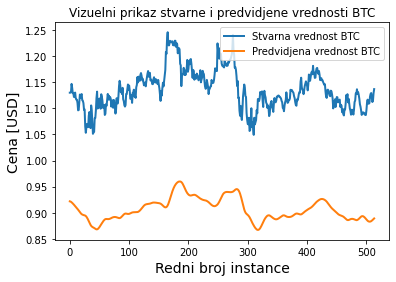

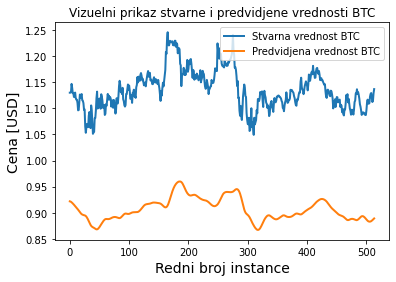

In [ ]:
# Plotovanje stvarne i predvidjene vrednosti

# Bez validacije
plot_real_vs_predicted_data(test_set = y_test, predicted_set = y_predicted_no_validation)

# Sa validacijom
plot_real_vs_predicted_data(y_test, y_predicted_validation)

### **Vizualizacija metrika**

### **Funkcija gubitka**

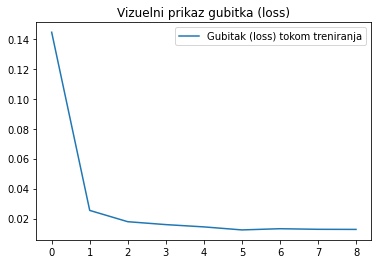

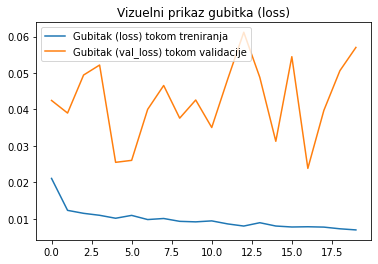

In [ ]:
# Vizuelni prikaz funkcije gubitka tokom treniranja mreze

# Bez validacije
plot_loss(history_ = history_no_validation)

# Sa validacijom
plot_loss(history_ = history_validation)

### **Srednja kvadratna greška**

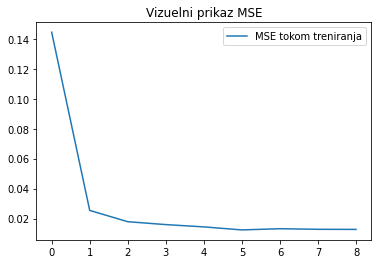

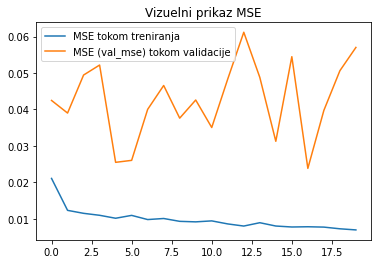

In [ ]:
# Plotovanje srednje kvadratne greske tokom treniranja mreze

# Bez validacije
plot_mse(history_ = history_no_validation)

# Sa validacijom
plot_mse(history_ = history_validation)

### **Srednja apsolutna greška**

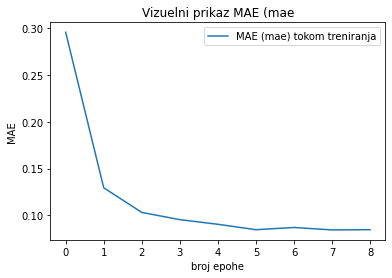

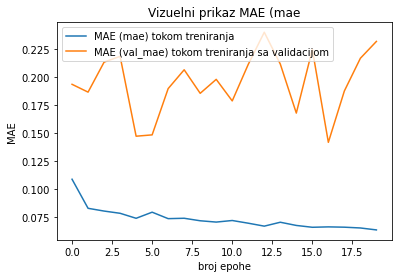

In [ ]:
# Vizualizacija srednje apsolutne greske tokom treniranja mreze

# Bez validacije
plot_mae(history_no_validation)

# Sa validacijom
plot_mae(history_validation)

### **Loss, MSE, MAE**

In [16]:
# Loss, MSE, MAE nad skupom za testiranje

# (za model koji pri treniranju koristi validaciju
# i za model koji pri treniranju ne koristi validaciju)

test_metrics_no_val = net_no_validation.evaluate(X_test, y_test)
test_metrics_val = net_validation.evaluate(X_test, y_test)

print('\nMetrike prilikom testiranja - model treniran bez validacije\n')
print(net_no_validation.metrics_names[0], test_metrics_no_val[0])
print(net_no_validation.metrics_names[1], test_metrics_no_val[1])
print(net_no_validation.metrics_names[2], test_metrics_no_val[2])

print('\n\nMetrike prilikom testiranja - model treniran sa validacijom\n')
print(net_validation.metrics_names[0], test_metrics_val[0])
print(net_validation.metrics_names[1], test_metrics_val[1])
print(net_validation.metrics_names[2], test_metrics_val[2])

NameError: name 'net_no_validation' is not defined

### **Koeficijent determinacije (R2 skor)**

In [ ]:
# R2 skor nad skupom za testiranje
from sklearn import metrics

r2 = metrics.r2_score(y_predicted_no_validation, y_test)
r2_val = metrics.r2_score(y_predicted_validation, y_test)

print('R2 skor prilikom testiranja - model treniran bez validacije', r2)
print('R2 skor prilikom testiranja - model treniran sa validacijom', r2_val)

R2 skor prilikom testiranja - model treniran bez validacije -117.98451421203194
R2 skor prilikom testiranja - model treniran sa validacijom -117.98451421203194
